This notebook explains how we can go about explore and prepare data for model building.The notebook is structured in the following way 

 - About Dataset
 - Data Summary
 - Feature Engineering
 - Missing Value Analysis
 - Outlier Analysis
 - Correlation Analysis
 - Visualizing Distribution Of Data
 - Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)
 - Filling 0's In Windspeed Using Random Forest
 - Linear Regression Model
 - Regularization Models
 - Ensemble Models

## About Dataset

#### **Overview**

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

#### **Data Fields**

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)

In [2]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

#### **Lets Read In The Dataset**

In [2]:
dailyData = pd.read_csv("/home/vivek/Documents/personal_contents/mycodes/kaggle/bike_sharing/train.csv")

## Data Summary

As a first step lets do three simple steps on the dataset

 - Size of the dataset
 - Get a glimpse of data by printing few rows of it.
 - What type of variables contribute our data

#### **Shape Of The Dataset**

In [3]:
dailyData.shape

(10886, 12)

#### **Sample Of First Few Rows**

In [4]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


#### **Variables Data Type**

In [5]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Feature Engineering

As we see from the above results, the columns "season","holiday","workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. Let us transform the dataset in the following ways so that we can get started up with our EDA

 - Create new columns "date,"hour","weekDay","month" from "datetime"
   column.
 - Coerce the datatype of "season","holiday","workingday" and weather to category.
 - Drop the datetime column as we already extracted useful features from it.

#### **Creating New Columns From "Datetime" Column**

In [6]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

#### **Coercing To Category Type**

In [7]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

#### **Dropping Unncessary Columns**

In [8]:
dailyData  = dailyData.drop(["datetime"],axis=1)

#### **Lets Start With Very Simple Visualization Of Variables DataType Count**

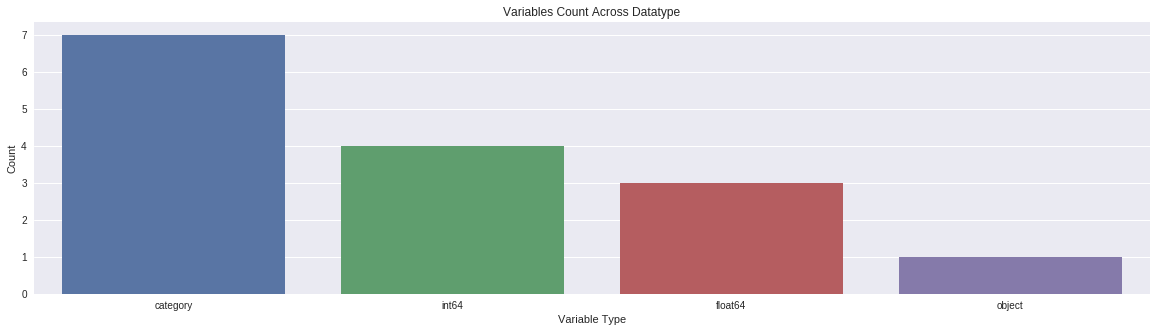

In [9]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

## Missing Values Analysis

Once we get hang of the data and columns, next step we geneally is to find out whether we have any missing values in our data. Luckily we dont have any missing value in the dataset. One way which I generally prefer to visualize missing value in the dataset is through "missingno".

Its a quiet handy library to quickly visualize variables for missing values. As I mentioned earlier we got lucky this time as there no missing value in the dataset.

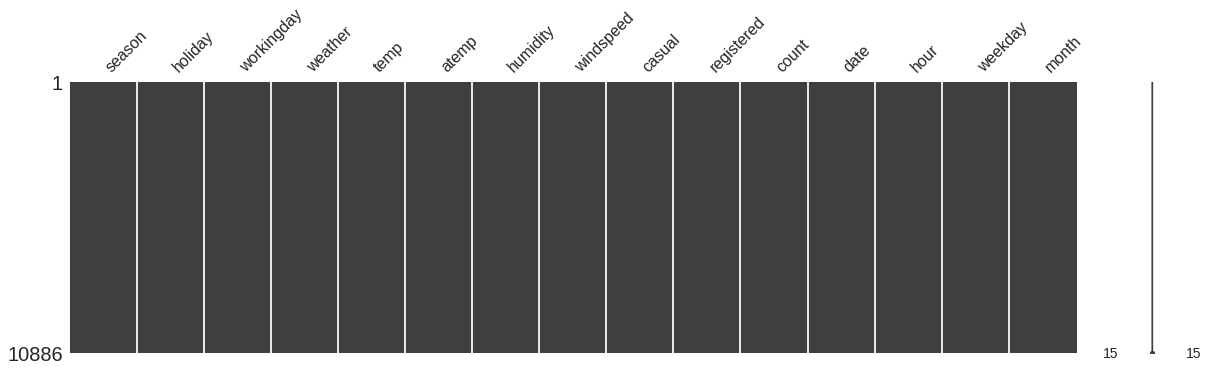

In [10]:
msno.matrix(dailyData,figsize=(20,5))

## Outliers Analysis

At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).But in addition to that, following inferences can also been made from the simple boxplots given below.

 - Spring season has got relatively lower count.The dip in median value
   in boxplot gives evidence for it.
 - The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time. 
 - Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4.

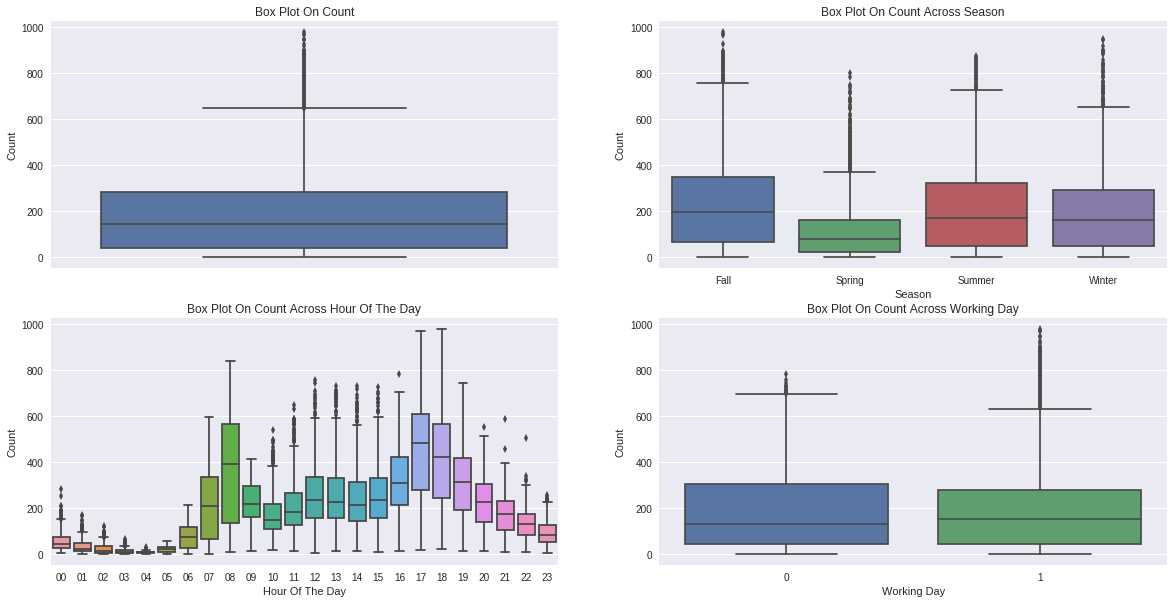

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

#### **Lets Remove Outliers In The Count Column**

In [12]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

In [13]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


## Correlation Analysis

One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and ["temp","atemp","humidity","windspeed"].

 - temp and humidity features has got positive and negative correlation
   with count respectively.Although the correlation between them are not
   very prominent still the count variable has got little dependency on
   "temp" and "humidity".
 - windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
 - "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
 - "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

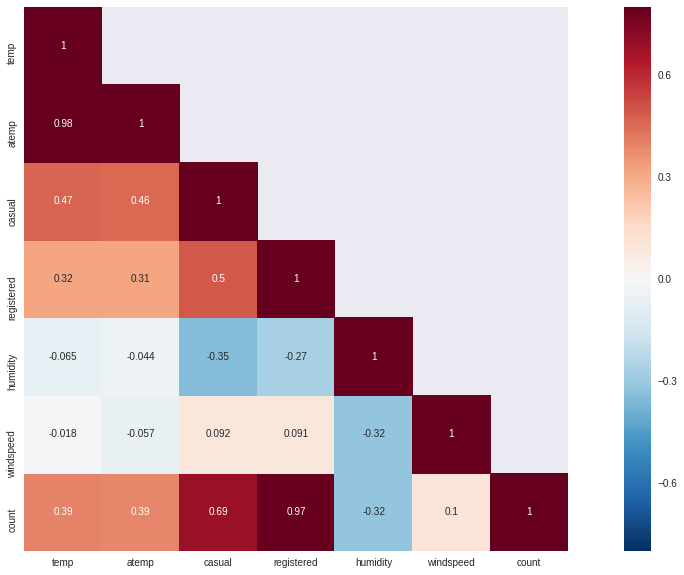

In [14]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

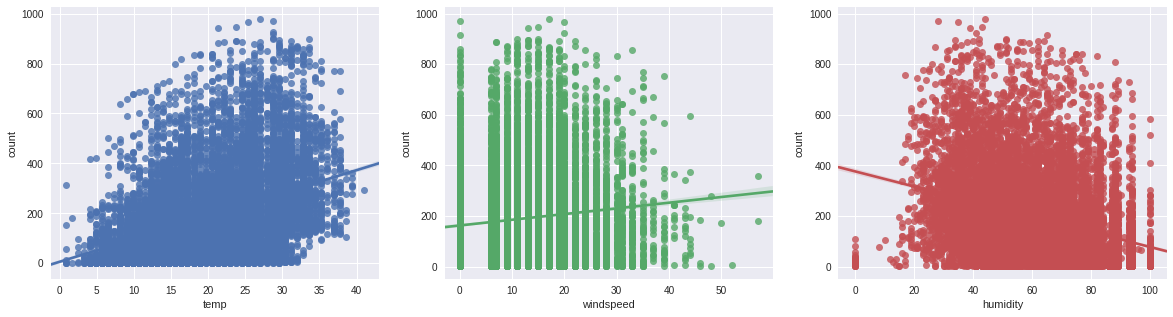

In [15]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

## Visualizing Distribution Of Data
As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

/home/vivek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.5971457 ,
          6.59850903,  6.5998705 ])),
 (1.3486990121229767, 4.5624238680878078, 0.95811767809096104))

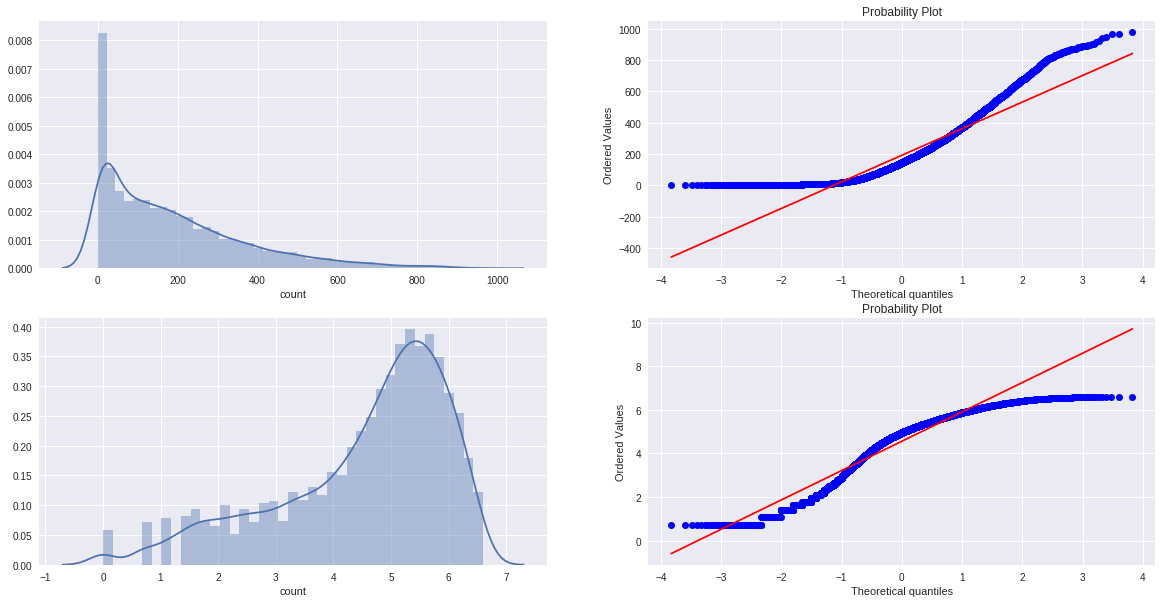

In [16]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

## Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)

 - It is quiet obvious that people tend to rent bike during summer
   season since it is really conducive to ride bike at that
   season.Therefore June, July and August has got relatively higher
   demand for bicycle.
 - On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
 - Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
 - The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

 None]

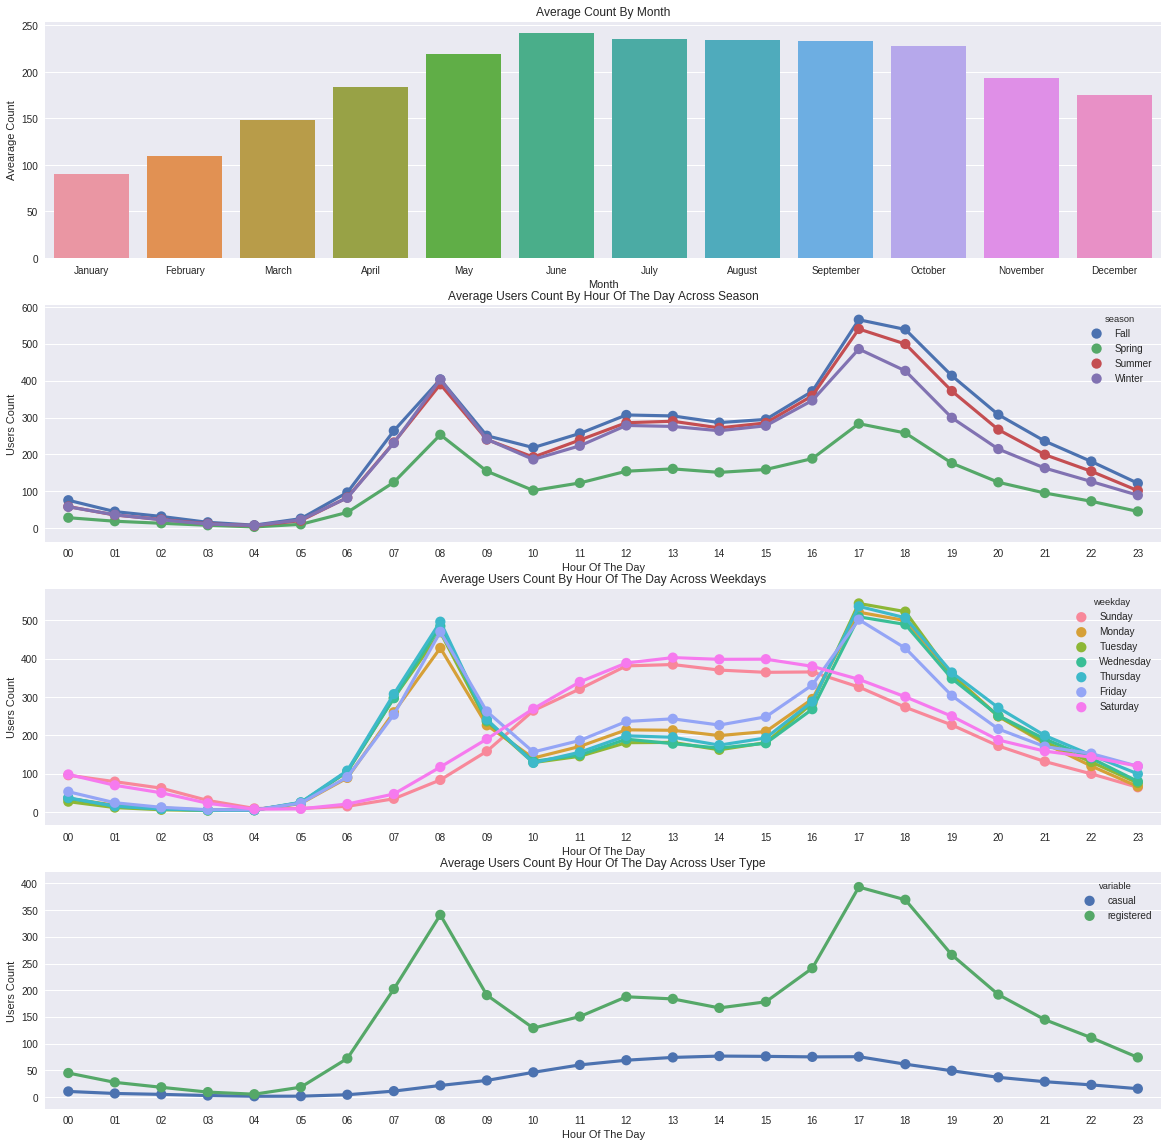

In [17]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

**So we have visualized the data to a greater extent.So lets go and  build some models and see how close we can predict the results.**

## Filling 0's In windspeed Using Random Forest ##

**Lets Read In Train And Test Data**

In [3]:
dataTrain = pd.read_csv("/home/vivek/Documents/personal_contents/mycodes/kaggle/bike_sharing/train.csv")
dataTest = pd.read_csv("/home/vivek/Documents/personal_contents/mycodes/kaggle/bike_sharing/test.csv")

**Combine Train And Test**

In [4]:
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

**Feature Engineering**

In [5]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
dataWindspeedOriginal = data["windspeed"]

**Distribution Of Windspeed Before Imputing**

 None]

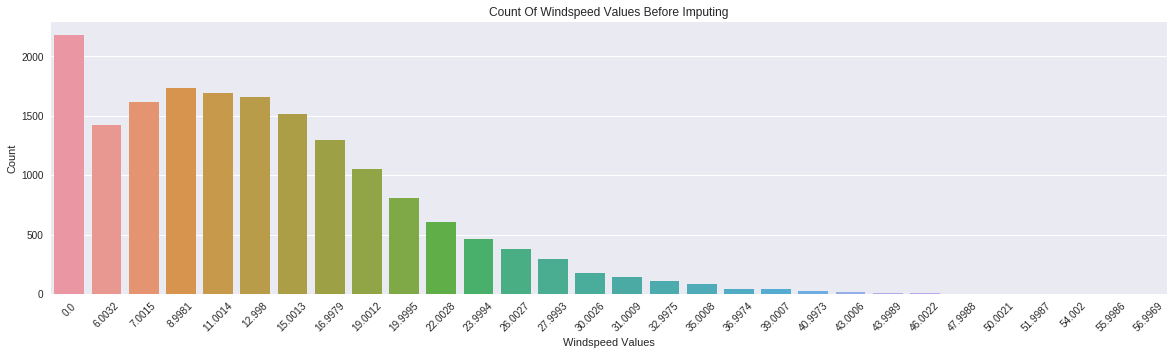

In [6]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values Before Imputing",label='big')

**Random Forest Model To Predict 0's In Windspeed**

In [7]:
from sklearn.ensemble import RandomForestClassifier

windColumns = ["season","weather","humidity","month","temp","year","atemp"]
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

rfModel_wind = RandomForestClassifier()
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])

dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data["windspeed"] = data["windspeed"].astype("float")
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

**Distribution Of Windspeed After Imputing**

 None]

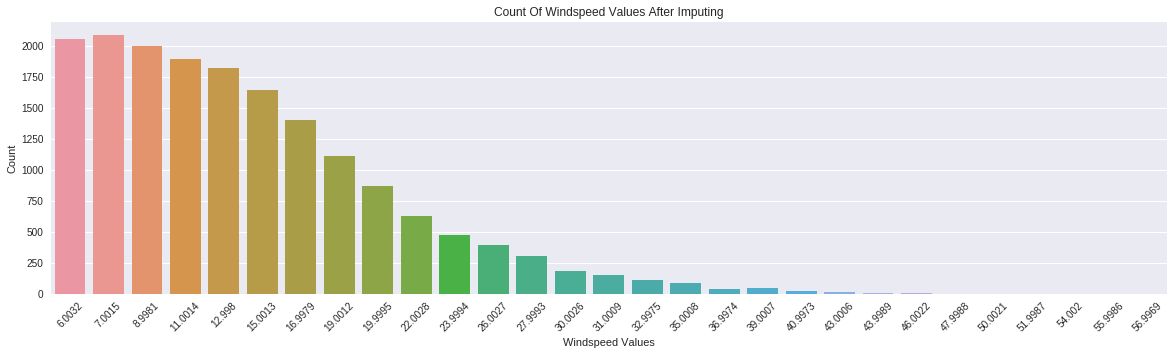

In [8]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values After Imputing",label='big')

**Coercing To Categorical Type**

In [10]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [11]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

**Splitting Train And Test Data**

In [13]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
# yLablesRegistered = dataTrain["registered"]
# yLablesCasual = dataTrain["casual"]

**Train and validator Split**

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split( dataTrain, yLabels, test_size=0.3, random_state=42)
dateTimeColValidate = X_validate["datetime"]

**Dropping  Unncessary Variables**

In [15]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)
X_train = X_train.drop(dropFeatures,axis=1)
X_validate = X_validate.drop(dropFeatures,axis=1)

**RMSLE Scorer**

In [17]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [18]:
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

## **Linear Regression Model** ##

In [24]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X = X_train,y = np.log1p(y_train))

# Make predictions
preds = lModel.predict(X= X_validate)
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))


RMSLE Value For Linear Regression In Validation:  0.983071037739


**Visualizing Distribution Of Train And Test**

/home/vivek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


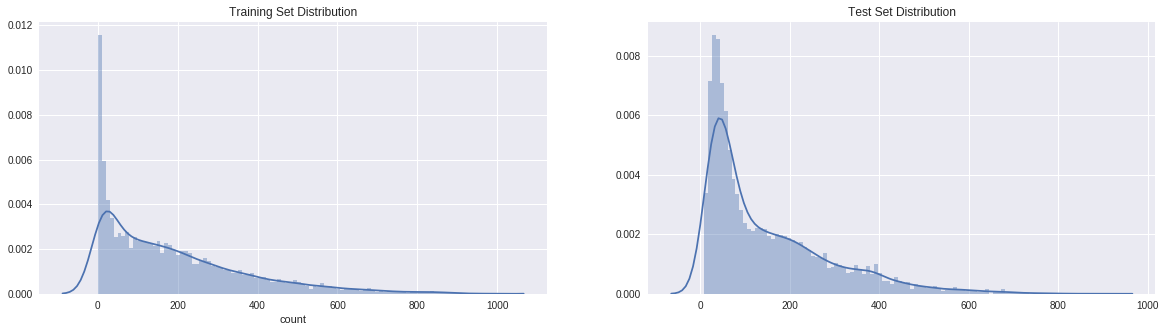

In [22]:
predsTest = lModel.predict(X=dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distribution")
ax2.set(title="Test Set Distribution")

## **Regularization Model -  Ridge** ##

{'alpha': 100, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.983144169959


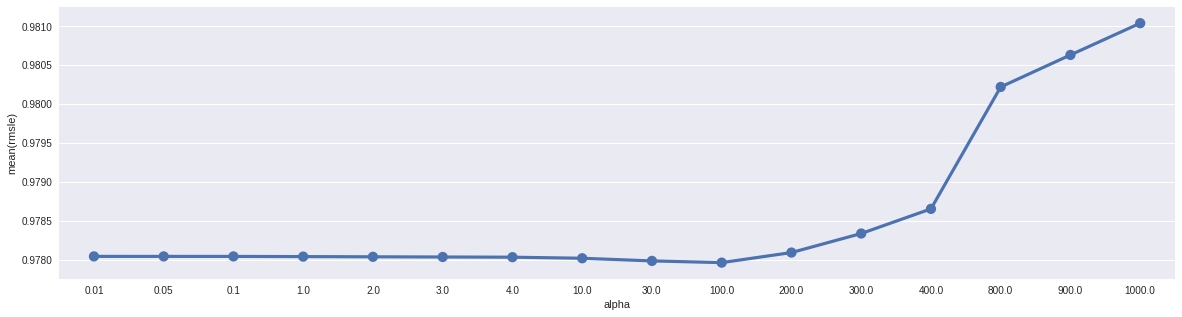

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01,0.05,0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
grid_ridge_m.fit(X = X_train,y = np.log1p(y_train))
preds = grid_ridge_m.predict(X= X_validate)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(20,5)
df = pd.DataFrame(grid_ridge_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## **Regularization Model - Lasso** ##

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.983083421084


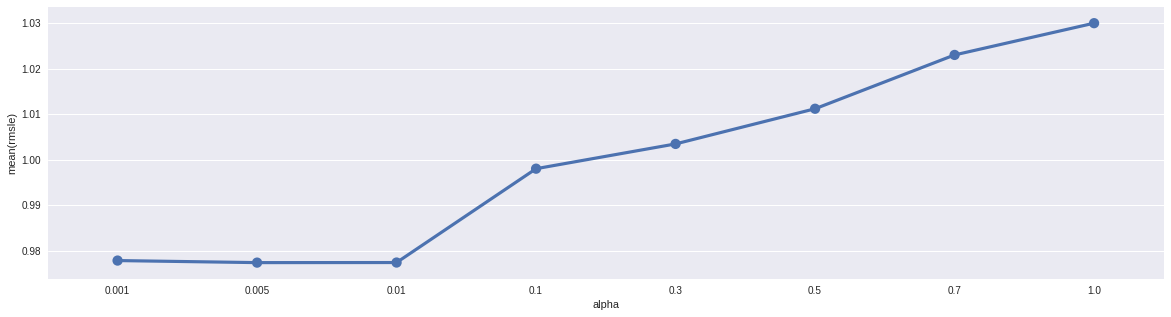

In [26]:
from sklearn.linear_model import Lasso
lasso_m_ = Lasso()

alpha  = [0.001,0.005,0.01,0.3,0.1,0.3,0.5,0.7,1]
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit(X = X_train,y = np.log1p(y_train))
preds = grid_lasso_m.predict(X= X_validate)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(20,5)
df = pd.DataFrame(grid_lasso_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## **Ensemble Models - Random Forest** ##

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfModel = RandomForestRegressor(n_estimators=100) ### Test 0.44
rfModel.fit(X = X_train,y = np.log1p(y_train))
preds = rfModel.predict(X= X_validate)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

RMSLE Value For Random Forest:  0.284294493295


**Feature Importance By Random Forest**

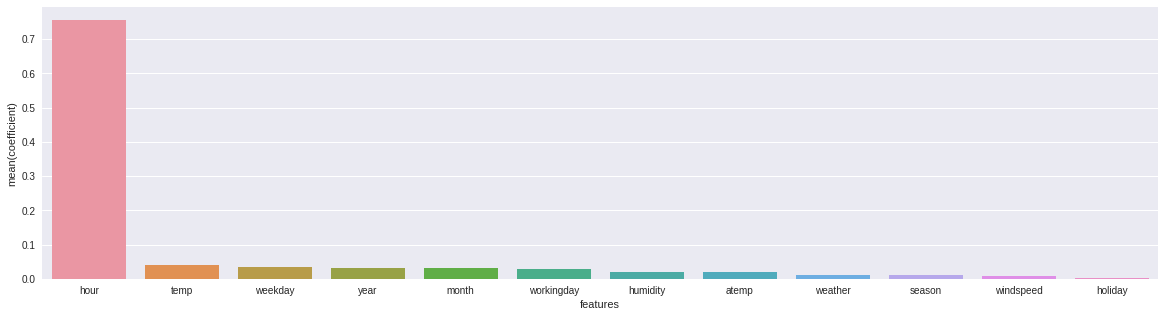

In [29]:
features = pd.DataFrame()
features['features'] = X_train.columns
features['coefficient'] = rfModel.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=features,x="features",y="coefficient",ax=ax)

## **Ensemble Model - Gradient Boost** ##

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01) ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(X = X_train,y = np.log1p(y_train))
preds = gbm.predict(X= X_validate)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.274506810421


**Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical. It  confirms visually that our model has not predicted really bad and not suffering from major overfitting problem.**

/home/vivek/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


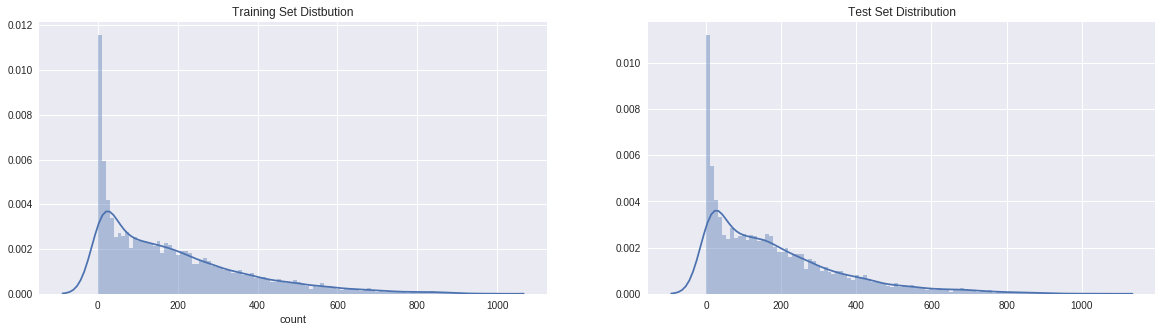

In [31]:
predsTest = gbm.predict(X=dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distbution")
ax2.set(title="Test Set Distribution")

In [34]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)

## Grid Search

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

gbm = GradientBoostingRegressor()

# Best Grid Result n_estimators=1000,alpha=0.1,subsample=0.4,max_features="auto",max_depth=20,min_samples_leaf=50,min_samples_split=25
param_grid = { 
    'n_estimators': [1000,2000,3000,4000],
    'max_features': ["auto","sqrt","log2",0.6,0.8],
    'min_samples_leaf':[30,40,50,60,70],
    'min_samples_split':[150,200,250,300],
    'max_depth' : [10,15,20,25],
    'subsample': [0.4,0.6,0.8],
    'learning_rate':[0.1,0.01,0.001]
}
yLabelsLog = np.log1p(yLabels)
CV_gbm= RandomizedSearchCV(estimator=gbm, param_distributions=param_grid,n_iter=75)
CV_gbm.fit(dataTrain, yLabelsLog)
print (CV_gbm.best_params_)

preds = CV_gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

## XGBoost Modelling

In [ ]:
import xgboost as xgb
import time
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

def run_xgb(train, test, features, target, random_state=0):
    print (features,target)
    eta = 0.1
    max_depth = 3
    subsample = 0.7
    colsample_bytree = 0.7
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "reg:linear",
        #"num_class": 12,
        "booster" : "gbtree",
        "eval_metric": "rmse",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state,
    }
    num_boost_round = 10000
    early_stopping_rounds = 50
    test_size = 0.3

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    print('Length train:', len(X_train.index),X_train.shape)
    print('Length valid:', len(X_valid.index),X_valid.shape)
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)

    watchlist = [(dtrain, 'train'), (dtrain, 'eval')]
    print (watchlist)
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[features]), ntree_limit=gbm.best_iteration)
    score = True #log_loss(y_valid.tolist(), check)

    print("Predict test set...")
    test_prediction = gbm.predict(xgb.DMatrix(test[features]), ntree_limit=gbm.best_iteration)

    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    return test_prediction.tolist(), score


dataTrain["count"] = yLabels
features = features = list(dataTest.columns.values)
test_prediction, score = run_xgb(dataTrain, dataTest, features, 'count')


**The submission will have test score of 0.41**

** To Fork Script From Kaggle**

["Kaggle Script To Finish Top Ten Percentile"]("https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile")
